In [1]:
# !pip install highway-env
# !pip install git+https://github.com/DLR-RM/stable-baselines3
# !pip install tensorboardx gym pyvirtualdisplay
# !apt-get install -y xvfb python-opengl ffmpeg
# !git clone https://github.com/eleurent/highway-env.git 2> /dev/null
# !git clone https://github.com/avivg7/highway-config.git
# !pip install tensorboard
# !pip install xvfbwrapper

In [24]:
from cffi import FFI
import os

ffi = FFI()
ffi.cdef("""
/* from stdio.h */
FILE* fopen(const char* path, const char* mode);
int fclose(FILE* fp);
FILE* stderr;  /* GNU C library */
FILE* __stderrp;  /* Mac OS X */
""")
try:
    stdio = ffi.dlopen(None)
    devnull = stdio.fopen(os.devnull.encode(), b'w')
except OSError:
    pass
try:
    stdio.stderr = devnull
except KeyError:
    try:
        stdio.__stderrp = devnull
    except KeyError:
        stdio.fclose(devnull)

/opt/conda/lib/python3.7/site-packages/cffi/cparser.py:165: UserWarning: Global variable 'stderr' in cdef(): for consistency with C it should have a storage class specifier (usually 'extern')
  "(usually 'extern')" % (decl.name,))
/opt/conda/lib/python3.7/site-packages/cffi/cparser.py:165: UserWarning: Global variable '__stderrp' in cdef(): for consistency with C it should have a storage class specifier (usually 'extern')
  "(usually 'extern')" % (decl.name,))


In [25]:
# General
import sys
sys.path.insert(0, '/content/highway-env/scripts/')
import io
import base64
import os
from tqdm.notebook import trange
import numpy as np
import random
import math
import pygame
import json
import ast
from pprint import pprint 
import glob
from collections import Counter
import datetime

# Local
from final_project.display_utils import wrap_env, show_video
from models.agent import Agent
from models.utils import plot_learning_curve

# Gym Env
import gym
import highway_env
# from utils import record_videos, show_videos
from gym import logger as gymlogger
from gym.wrappers import Monitor
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only

# Neural Networks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Visualization
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay

%load_ext tensorboard
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [10]:
display = Display(visible=0, size=(1400, 900))
display.start()

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [3]:
torch.cuda.is_available()

True

In [4]:
#=============== DO NOT DELETE ===============
# file = open('/content/highway-config/config_ex1.txt', 'r')
# contents = file.read()
# config1 = ast.literal_eval(contents)
# file.close()
# ============================================

file = open('./highway-config/config_ex1.txt', 'r')
contents = file.read()
# print(contents)
config1 = ast.literal_eval(contents)
file.close()

env = gym.make("highway-fast-v0")
env.configure(config1)
# env = wrap_env(env)
env.reset()
# env.config

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[99., 99., 99., ..., 99., 99., 99.],
        [99., 99., 99., ..., 99., 99., 99.],
        [99., 99., 99., ..., 99., 99., 99.],
        ..

In [7]:
# a = np.max(observation)

# while a == 0:
#     action = env.action_space.sample()
#     observation, reward, done, _ = env.step(action)
#     a = np.max(observation)
# print(f'np.max(observation): {np.max(observation)}')
# print(f'np.min(observation): {np.min(observation)}')    
# for i in range(100):
#     action = env.action_space.sample()
#     observation, reward, done, _ = env.step(action)

#     pprint(action)
# # pprint(observation)
#     print(f'np.max(observation): {np.max(observation)}')
#     print(f'np.min(observation): {np.min(observation)}')

In [5]:
env.observation_space.shape

(4, 128, 128)

In [9]:
# del agent

In [ ]:
n_games = 500
figure_file = 'plots/highway_500'
torch.autograd.set_detect_anomaly(True)
# print(env.observation_space.shape)
agent = Agent(input_dims=env.observation_space.shape,
              env=env,
              n_actions=5,
              max_size=10000)

best_score = env.reward_range[0]
top_score = env.reward_range[0]
score_history = []
load_checkpoint = True

if load_checkpoint:
    agent.load_models()
    env.render(mode='human')
    
for i in range(n_games):
    action_history = []
    observation = env.reset()
    done = False
    score = 0
    steps = 0
    while not done:
        steps += 1
        action = agent.choose_action(observation)
        action_history.append(action)
        salt = np.random.rand()
        if salt > 0.15:
            new_observation, reward, done, info = env.step(action)
            # if action == 4 and salt < 0.95:
            #     reward = 0.8*reward
        else:
            new_observation, reward, done, info = env.step(env.action_space.sample())
        score += reward
        # print(f'observation.shape: {observation.shape}')
        agent.remember(observation, action, reward, new_observation, done)
        if not load_checkpoint:
            agent.learn()
        observation = new_observation
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    
    top_score = max(score, top_score)
    if avg_score > best_score:
        best_score = avg_score
        if not load_checkpoint:
            agent.save_models()
    
    screen = env.render(mode='rgb_array')
    plt.imshow(screen)
    print(f'Episode: {i}, Best Score {best_score}, Average Score: {avg_score}, Top Score: {top_score}, Steps: {steps}')
    counts = np.bincount(action_history)
    counts = counts/np.sum(counts)
    counts = zip(counts, ["Left", "Idle", "Right", "Faster", "Slower"])
    print(f'action_history: {counts}, time: {datetime.datetime.now()}\n')
    
if not load_checkpoint:
    x = [i+1 for i in range(n_games)]
    plot_learning_curve(x, score_history, figure_file)

(10000, 4, 128, 128)
4 128 128


/home/jupyter/highway-rl/models/agent.py:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/torch/csrc/utils/tensor_new.cpp:210.)
  state = T.Tensor([observation]).to(self.actor.device)
/home/jupyter/highway-rl/models/networks.py:138: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = F.softmax(prob)


Episode: 0, Best Score 5.713906431991677, Average Score: 5.713906431991677, Top Score: 5.713906431991677, Steps: 7
action_history: [0 1 1 4 1]

Episode: 1, Best Score 6.523869390395233, Average Score: 6.523869390395233, Top Score: 7.333832348798789, Steps: 10
action_history: [2 1 2 9 3]

Episode: 2, Best Score 10.996249713810194, Average Score: 10.996249713810194, Top Score: 19.941010360640117, Steps: 21
action_history: [ 4  2  3 25  4]

Episode: 3, Best Score 10.996249713810194, Average Score: 9.645020346895755, Top Score: 19.941010360640117, Steps: 7
action_history: [ 6  3  3 28  5]

Episode: 4, Best Score 10.996249713810194, Average Score: 9.247153412217427, Top Score: 19.941010360640117, Steps: 10
action_history: [ 6  5  3 34  7]

Episode: 5, Best Score 10.996249713810194, Average Score: 8.924037654638898, Top Score: 19.941010360640117, Steps: 9
action_history: [ 6  5  4 40  9]

Episode: 6, Best Score 10.996249713810194, Average Score: 8.970072086529148, Top Score: 19.9410103606401

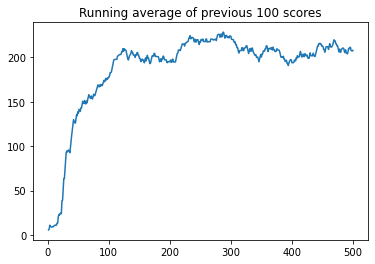

In [14]:
if not load_checkpoint:
    x = [i+1 for i in range(n_games)]
    plot_learning_curve(x, score_history, figure_file)

In [23]:
# #=============== DO NOT DELETE ===============
# file = open('./highway-config/config_ex1.txt', 'r')
# contents = file.read()
# config1 = ast.literal_eval(contents)
# file.close()
# # ============================================
# del env

env = gym.make("highway-fast-v3")
env.configure(config1)

n_games = 500
figure_file = 'plots/highway_500'
torch.autograd.set_detect_anomaly(True)
# print(env.observation_space.shape)
agent = Agent(input_dims=env.observation_space.shape,
              env=env,
              n_actions=5,
              max_size=10000)

load_checkpoint = True

if load_checkpoint:
    agent.load_models()
    env.render(mode='human')


env = wrap_env(env)
observation = env.reset()
done = False
iter = 0

while not done:
    if done:
        break
    iter +=1
    action = agent.choose_action(observation)
    salt = np.random.rand()
    if salt > 0.15:
        new_observation, reward, done, info = env.step(action)
    else:
        new_observation, reward, done, info = env.step(env.action_space.sample())
    screen = env.render(mode='rgb_array')
    plt.imshow(screen)
    # print(f'iteration: {iter}, action: {action}, reward: {reward}, done: {done}')
print(f"Number of steps: {iter}")
env.close()
show_video()

DeprecatedEnv: Env highway-fast-v3 not found (valid versions include ['highway-fast-v0'])

In [21]:
# env.close()
# show_video()